# New Business Location Analysis

Recently an owner of a sensory depreviation - floating tank business approached me to ask if it was possible to find the best possible position for a new business location. In order to do this I conducted some research into the business and its products, below are some example competitors:

1. https://www.twfloat.com/
2. https://www.stressreliefcenter.com/services/ocean-float-room/
3. http://www.floatsixty.com/
4. https://floatstation.com/

Given that the product offered requires complete isolation, there are a number of factors that may affect the quality of the customer experience. Below in Figure 1 we can see the mind map of the factors which may influence the location.

#### Figure 1: Mindmap
![Figure 1: Mindmap](https://bitbucket.org/intrinsy/l_line/raw/master/reports/figures/business_mindmap.jpg)

Now we want to have various data sources, these include the train data but can be augmented with the following sources:

1. [Open Data Chicago](https://catalog.data.gov/dataset?tags=cta&publisher=data.cityofchicago.org)
2. [Zillow](https://www.zillow.com/howto/api/APIOverview.htm)
3. [Census data](https://www.census.gov/developers/)
4. [Yelp](https://www.yelp.com/developers/documentation/v3/business)
5. [OpenAddress.IO](https://openaddresses.io/)
6. [geopy](https://github.com/geopy/geopy)
7. [OpenStreetMap](https://www.openstreetmap.org/)

With this combination of data sources we can start to combine the data into information. Below are examples of some of the questions that could be answered.

1. What are the quietest areas in Chicago?
    * Which train stations have the least busy times?
    * What is the population density for each area?
    * What areas have police, fire, hospitals nearby?
    * Are large events held nearby?
    * Are there major roads nearby?
2. What areas best match the target cusomtomer for the business?
3. Where are the competing businesses located?
4. What is the rent in the preferred locations?

## User interaction

In order to sift through the multiple dimensions to the data there are a number of ways that it could be consumed. A business owner is likely to be time poor and would like to recieve a recommnedation. This is particularly the case if they are only opening one location. Further this seems to be a nieche business, however the core concepts could be extended into a business location selection product.

The data and choice is very spatial in nature, the natural way to communicate the findings is by analyzing some locations and creating a rule set that the business owner can easily apply when assesing a location. This removes the need for a computation heavy solution. A user can easily check the distance to points of interest by using google maps and then perhaps create a ranking number based on this.

How do business people currently choose a new location?

#### Figure 2: User current workflow
![Figure 2: User_1](https://bitbucket.org/intrinsy/l_line/raw/master/reports/figures/user_1.jpg)
![Figure 3: User_2](https://bitbucket.org/intrinsy/l_line/raw/master/reports/figures/user_2.jpg)

In this example we can see that the current method involves search for commercial realestate then making a business decision based off of previous experience and information gathered by the business person. So much of this is still left to chance.

What if we could join multiple data sets to give the user a more informed view, and let them interact with the current availiable locations. Then easily book an appointment to inspect the potential premises?

This work flow could be built to look something like this:
![Figure 4: Product](https://bitbucket.org/intrinsy/l_line/raw/master/reports/figures/product_views.jpg)

### Questions to be validated

1. What do you spend the most time on currently when looking for a new location?
2. What would save you time?
3. What would make your business more successful?
4. How could you use this information to make a better business case?

These and more questions need to be explored before deciding to build a product, if there is no need or if the time savings are more focussed around the relationship with realestate agents another approach maybe more suitable.

## PoC

1. Find commerical locations for rent
2. Attribute data to the locations
3. Formulate a matematical approach to select the best location
4. Run model
5. Examine solutions

In [10]:
# All units in metric
# rent - $USD - the cost of the location per month
# train_d - distance to the nearest train stop in meters
# train_t - the average number of passengers in meters
# competition - the distance to the nearest competitor in meters
# demo - the % of match for the target customer market
# police - the distance to the nearest police station in meters
# fire - the distance to the nearest fire station in meters
# capacity - the capacity of the location
# ... more to be added
potential_locations = {
    'one': {
        'rent': 1000,
        'train': 500,
        'competition': 2000,
        'demo': 50,
        'police': 100,
        'fire': 500,
        'capacity': 10
    },
    'two': {
        'rent': 3000,
        'train': 1000,
        'competition': 1000,
        'demo': 90,
        'police': 500,
        'fire': 300,
        'capacity': 5
    },
    'three': {
        'rent': 10000,
        'train': 100,
        'competition': 100,
        'demo': 70,
        'police': 200,
        'fire': 50,
        'capacity': 200
    },
    'four': {
        'rent': 500,
        'train': 10,
        'competition': 10,
        'demo': 40,
        'police': 100,
        'fire': 50,
        'capacity': 25
    },
    'five': {
        'rent': 5000,
        'train': 1500,
        'competition': 12000,
        'demo': 60,
        'police': 1000,
        'fire': 2000,
        'capacity': 100
    },
}

In [41]:
import pulp

SOLVER = pulp.solvers.GLPK()

In [120]:
# declare your variables
x1 = pulp.LpVariable("x1", 0, 1, cat='Integer')   # 0<= x1 <= 1
x2 = pulp.LpVariable("x2", 0, 1, cat='Integer')   # 0<= x2 <= 1
x3 = pulp.LpVariable("x3", 0, 1, cat='Integer')   # 0<= x3 <= 1
x4 = pulp.LpVariable("x4", 0, 1, cat='Integer')   # 0<= x4 <= 1
x5 = pulp.LpVariable("x5", 0, 1, cat='Integer')   # 0<= x5 <= 1

# defines the problem
prob = pulp.LpProblem("problem", LpMinimize)

Now let's make an objective function that preferences the behaviour we want
1. Preference furtherest distance from train, competition, police and fire
2. We can tolerate being close to these if we get more capacity
3. We can also tolerate these if the rent is lower

((X * rent) / capacity) - (X * sum(train, competition, police, fire))


In [121]:
location_to_variable = {'one': x1, 'two': x2, 'three': x3, 'four': x4, 'five': x5}
# define the objective function

prob += pulp.LpAffineExpression((location_to_variable[k], v['rent'] / v['capacity'] * 10) for k, v in potential_locations.items())
prob += pulp.LpAffineExpression((location_to_variable[k], (v['train'] + v['competition'] + v['police'] + v['fire']) * 100) for k, v in potential_locations.items())

# add max rent constraints
max_rent = 5000
lhs = pulp.LpAffineExpression((location_to_variable[k], v['rent']) for k, v in potential_locations.items())
rhs = max_rent
prob += (lhs <= rhs)

/anaconda3/envs/py36/lib/python3.6/site-packages/pulp/pulp.py:1348: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


In [122]:
# add min demographic match constraints
min_match = 50
lhs = pulp.LpAffineExpression((location_to_variable[k], v['demo']) for k, v in potential_locations.items())
rhs = min_match
prob += (lhs >= rhs)

In [123]:
# add min capacity constraints
min_capacity = 10
lhs = pulp.LpAffineExpression((location_to_variable[k], v['capacity']) for k, v in potential_locations.items())
rhs = min_capacity
prob += (lhs >= rhs)

In [124]:
# add one selection constraint
lhs = pulp.LpAffineExpression((location_to_variable[k], 1) for k, v in potential_locations.items())
rhs = 1
prob += (lhs >= rhs)

In [125]:
prob.writeLP("../models/test.lp")
status = prob.solve()

In [126]:
solution = None
for k in potential_locations.keys():
    selected = value(location_to_variable[k])
    if selected:
        solution = k

In [127]:
solution

'four'

There using this model we have selected number 4

Now that we have a selection we want to ensure that this selection will be reasonable in the future
* Lets assume our selection is closest to the following train station, 'station_id': '40850','stationname': 'Library'


In [291]:
import json
import pandas as pd

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

l_line_raw = None
with open('../data/raw/l_line.json') as l:
    l_line_raw = json.load(l)

for d in l_line_raw:
    d['rides'] = int(d['rides'])

data_keys = l_line_raw[0].keys()
l_df = pd.DataFrame([[d[k] for k in data_keys] for d in l_line_raw], columns=data_keys)

In [292]:
l_df = l_df.set_index('station_id')

In [293]:
station_data = l_df.loc['40850']

In [294]:
station_data['date'] = pd.to_datetime(station_data.date)

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [295]:
station_data = station_data.sort_values(by='date')
station_data

date daytype  rides stationname
station_id                                      
40850      2001-09-02       U    492     Library
40850      2002-04-23       W   2731     Library
40850      2003-03-01       A    902     Library
40850      2004-10-09       A   1057     Library
40850      2008-06-27       W   4036     Library
40850      2010-06-30       W   4693     Library
40850      2012-09-19       W   5357     Library
40850      2013-02-23       A   2251     Library
40850      2017-10-09       W   3939     Library

In [296]:
time_difference = [0]
days = 0.
s_values = station_data.values
for i in range(len(s_values)):
    if i != 0:
        days += (s_values[i][0] - s_values[i - 1][0]).days
        time_difference.append(days)
station_data['days'] = time_difference

In [301]:
X = station_data.days.get_values().tolist()
y = station_data.rides.get_values().tolist()

tstat, pval = stats.ttest_1samp(X, 0)
print("Comparison of the mean of X to 0.\nT-statistic = %s; P-value = %s." % (tstat, pval))

tstat, pval = stats.ttest_1samp(X, 1)
print("Comparison of the mean of x to 1.\nT-statistic = %s; P-value = %s." % (tstat, pval))

Comparison of the mean of X to 0.
T-statistic = 3.5042047269554963; P-value = 0.00802945574449398.
Comparison of the mean of x to 1.
T-statistic = 3.5027535101994407; P-value = 0.008046547143998082.


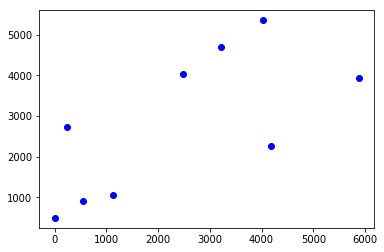

In [302]:
#plot the data
plt.plot(station_data['days'], station_data['rides'], 'bo')
plt.show()

In [305]:
results = smf.ols('y ~ X', {'X': X, 'y': y}).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     6.346
Date:                Thu, 15 Mar 2018   Prob (F-statistic):             0.0399
Time:                        15:38:31   Log-Likelihood:                -76.672
No. Observations:                   9   AIC:                             157.3
Df Residuals:                       7   BIC:                             157.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1398.7597    729.453      1.918      0.0

/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


In [307]:
intercept, slope = results.params
r2 = results.rsquared
print(slope, intercept, r2)

0.5921757297233323 1398.759671294726 0.4754973396605727


/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


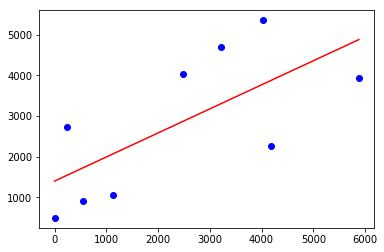

In [323]:
plt.plot(X, y, 'bo')
plt.hold(True)
x = np.array([min(X), max(X)])
y = np.asarray(intercept) + np.asarray(slope) * X
plt.plot(X, y, 'r-')
plt.show()

It seems like there are two trend lines. Lets seperate out the weekdays and the non weekdays

In [332]:
just_week_days = station_data[station_data['daytype'] == 'W']
time_difference = [0]
days = 0.
s_values = just_week_days.values
for i in range(len(s_values)):
    if i != 0:
        days += (s_values[i][0] - s_values[i - 1][0]).days
        time_difference.append(days)
just_week_days['days'] = time_difference
just_week_days

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


date daytype  rides stationname    days
station_id                                              
40850      2002-04-23       W   2731     Library     0.0
40850      2008-06-27       W   4036     Library  2257.0
40850      2010-06-30       W   4693     Library  2990.0
40850      2012-09-19       W   5357     Library  3802.0
40850      2017-10-09       W   3939     Library  5648.0

In [334]:
X2 = just_week_days.days.get_values().tolist()
y2 = just_week_days.rides.get_values().tolist()
results2 = smf.ols('y ~ X', {'X': X2, 'y': y2}).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     1.565
Date:                Thu, 15 Mar 2018   Prob (F-statistic):              0.300
Time:                        16:00:01   Log-Likelihood:                -39.913
No. Observations:                   5   AIC:                             83.83
Df Residuals:                       3   BIC:                             83.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3339.6201    767.105      4.354      0.0

/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


In [335]:
intercept, slope = results2.params
r2 = results.rsquared
print(slope, intercept, r2)

0.2761039348241533 3339.6200939778837 0.3427797224166266


/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


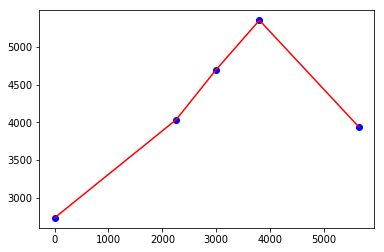

In [336]:
plt.plot(X2, y2, 'bo')
plt.hold(True)
x = np.array([min(X2), max(X2)])
y = np.asarray(intercept) + np.asarray(slope) * X2
plt.plot(X2, y2, 'r-')
plt.show()

there seems to be a dramatic drop from 2012 to 2017!